# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

C:\Users\srina\anaconda3\lib\site-packages\IPython\nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


Word count: 573


In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib as plt
from collections import Counter
import matplotlib.pyplot as plt
import bisect
import random
import re

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import datetime as dt
import time
import pytz

## 2. Imbalance task (SMOTE) – 1 A4 – Individual

#### Individual task of Srinath Jayaraman - 5049903

In [84]:
#df = pd.read_pickle("/work/data_lab_1.pkl")

df_x = df.drop(['bookingdate','simple_journal','txid'], axis=1, inplace=False) # Dropping "simple_journal" since it is the target variable

df_y = df.simple_journal.copy() # This is our target variable "y"

df.amount.iloc[np.where(df.amount.isnull())] = 0 #some amount fields contain null (not sure why) so making them zero

C:\Users\srina\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [85]:
# using unshuffled datasets to preserve any patterns in the timing of fraudulent cases

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier

smote_x, smote_y, = df_x.copy(), df_y.copy()

# starting off with 3 nearest neighbors, lets see how it goes
# weights = 'distance' --> this argument means that closer neighbors will have greater influence than distant ones.

knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance', n_jobs=-1) 
knn_model.fit(smote_x, smote_y)

# Trying to find the k nearest neighbors of the minority class, so we can oversample them
# Only training on the data that is fraudulent (or whatever has target label == 0), hence smote_y_train == 0
# If oversampling is 200% then knn is 2, 300% means knn is 3, and so on

smote_samples = knn_model.kneighbors(smote_x[smote_y == 0], n_neighbors=6, return_distance=False)

In [86]:
np.isnan(smote_samples).any()

False

In [89]:
smote_x.isnull().sum()

issuercountrycode                  0
txvariantcode                      0
bin                             1313
amount                             0
currencycode                       0
shoppercountrycode                 0
shopperinteraction                 0
cardverificationcodesupplied       0
cvcresponsecode                    0
creationdate                       0
accountcode                        0
mail_id                            0
ip_id                              0
card_id                            0
dtype: int64

In [88]:
# Performing SMOTE here
for samples in smote_samples:
    # randomizing bin as a start
    smote_x.loc[smote_samples[np.random.randint(0, smote_samples.shape[0])], 'bin'] = (smote_x.iloc[smote_samples[np.random.randint(0, smote_samples.shape[0])]].bin * np.random.uniform(0.01,1.0))#.astype('int')

In [90]:
smote_x.bin.iloc[np.where(smote_x.bin.isnull())] = np.random.randint(0, smote_x.shape[0])

C:\Users\srina\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [91]:
# No shuffling (to preserve any patterns in the timing of fraudulent cases)
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, train_size=0.8, random_state=12, shuffle=False)

smote_x_train, smote_x_test, smote_y_train, smote_y_test = train_test_split(smote_x, smote_y, test_size=0.3, random_state=12, shuffle=False)

In [106]:
df_y_test

232305    2
232306    2
232307    2
232308    2
232309    2
         ..
290377    2
290378    2
290379    2
290380    2
290381    2
Name: simple_journal, Length: 58077, dtype: int32

In [105]:
smote_y_test

203267    2
203268    2
203269    2
203270    2
203271    2
         ..
290377    2
290378    2
290379    2
290380    2
290381    2
Name: simple_journal, Length: 87115, dtype: int32

In [92]:
# 1) KNN:

KNN_smote = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
KNN_smote.fit(smote_x_train, smote_y_train)
KNN_smote.predict(smote_x_test)


KNN_unsmote = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
KNN_unsmote.fit(df_x_train, df_y_train)
KNN_unsmote.predict(df_x_test)

array([2, 2, 2, ..., 2, 2, 2])

In [93]:
KNN_smote.score(smote_x_test, smote_y_test)

0.4932560408655226

In [94]:
KNN_unsmote.score(df_x_test, df_y_test)

0.4148802451917282

In [95]:
# 2) Linear classifier
from sklearn.linear_model import SGDClassifier

LC_smote = SGDClassifier(max_iter=2000)
LC_smote.fit(smote_x_train, smote_y_train)
LC_smote.predict(smote_x_test)

LC_unsmote = SGDClassifier(max_iter=2000)
LC_unsmote.fit(df_x_train, df_y_train)
LC_unsmote.predict(df_x_test)

array([2, 2, 2, ..., 2, 2, 2])

In [96]:
LC_smote.score(smote_x_train, smote_y_train)

0.8941047981226663

In [97]:
LC_unsmote.score(df_x_train, df_y_train)

0.9073416413766384

In [99]:
# 3) Decision tree
from sklearn import tree

tree_smote = tree.DecisionTreeClassifier()
tree_smote.fit(smote_x_train, smote_y_train)
tree_smote.predict(smote_x_test)

tree_unsmote = tree.DecisionTreeClassifier()
tree_unsmote.fit(df_x_train, df_y_train)
tree_unsmote.predict(df_x_test)

array([2, 2, 2, ..., 1, 1, 1])

In [100]:
tree_smote.score(smote_x_train, smote_y_train)

0.9986372603521476

In [101]:
tree_unsmote.score(df_x_train, df_y_train)

0.9988032973892081

In [122]:
df_y

0         0
1         0
2         0
3         0
4         0
         ..
290377    2
290378    2
290379    2
290380    2
290381    2
Name: simple_journal, Length: 290382, dtype: int32

ValueError: KNeighborsClassifier should be a binary classifier

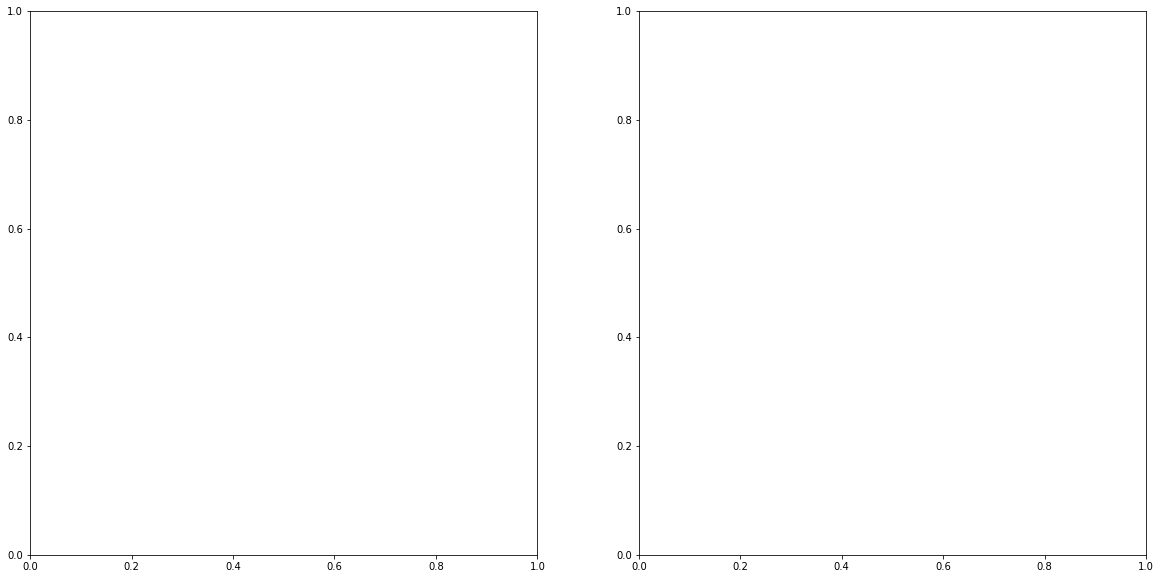

In [102]:
from sklearn.metrics import plot_roc_curve

f, (ax1, ax2) = plt.subplots(1,2,figsize =(20, 10))

KNN_unsmote_disp = plot_roc_curve(KNN_unsmote, df_x_test, df_y_test, ax=ax1)
LC_unsmote_disp = plot_roc_curve(LC_unsmote, df_x_test, df_y_test, ax=ax1)
tree_unsmote_disp = plot_roc_curve(tree_unsmote, df_x_test, df_y_test, ax=ax1)
ax1.set_title('ROC curve on the non-SMOTE data')

KNN_smote_disp = plot_roc_curve(KNN_smote, smote_x_test, smote_y_test, ax=ax2)
LC_smote_disp = plot_roc_curve(LC_smote, smote_x_test, smote_y_test, ax=ax2)
tree_smote_disp = plot_roc_curve(tree_smote, smote_x_test, smote_y_test, ax=ax2)
ax1.set_title('ROC curve on the SMOTE data')

plt.show()

### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

I was not able to print the ROC curves, but as a workaround I did print the scores of the different classifiers above. Decision tree works best and KNN performs the worst.

### 2c. Is using SMOTE a good idea? Why (not)?

In general, yes. SMOTE is not like random over sampling which essentially "copy pastes" minority class samples. Instead, it computes the distance between 2 random feature vectors of the minority classes and generates an artificial (aka synthetic) sample along that distance vector. This, combined with random undersampling of the majority class, tends to "fix" the imbalance of the dataset, thus improving the performance of ML algorithms.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad0f8f88-574f-4936-aedb-0b72571d8308' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>